In [1]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array
sns.set(rc={'figure.figsize':(20,10)})
tf.random.set_seed(42)

In [4]:
data_hor_disc = pd.read_excel("Data/DiscreteMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
data_hor_cont = pd.read_excel("Data/ContinuousMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
data_ver_disc = pd.read_excel("Data/DiscreteMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")
data_ver_cont = pd.read_excel("Data/ContinuousMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")

In [5]:
# Splitting the data
# Required input data format: 3D array [samples, timesteps, features], features = 1 here
# Or 4D array [samples, subsequences, timesteps, features]
def train_val_test(dataset, train_split, valid_split):
  x = dataset.index.to_numpy()
  y = dataset.to_numpy()

  # Split the data in training and remaining dataset
  x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=train_split, shuffle=False)

  # Split the remaining dataset into validation and testing
  x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, train_size=(valid_split/(1-train_split)), shuffle=False)

  return x_train, y_train, x_valid, y_valid, x_test, y_test

  # Reshaping to 4-dimensional array [samples, subsequences, timesteps, features]
  # x_train = x_train.reshape((dataset.size, len(dataset.columns), len(dataset), 1))

In [6]:
# Splitting the NORMALIZED data for single category
# Required input data format: 3D array [samples, timesteps, features], features = 1 here
# Or 4D array [samples, subsequences, timesteps, features]

def train_val_test_norm(dataset, train_split, valid_split, rpm):
  dataset['time_steps'] = range(0, 10*len(dataset), 10)
  dataset = dataset.melt("time_steps", var_name="Pow", value_name="Watts")
  dataset = dataset[dataset['Pow'] == rpm]
  dataset = dataset.sort_values('time_steps')
  x = dataset["time_steps"].to_numpy()
  y = dataset["Watts"].to_numpy()

  # Split the data in training and remaining dataset
  x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=train_split, shuffle=False)

  # Split the remaining dataset into validation and testing
  x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, train_size=(valid_split/(1-train_split)), shuffle=False)

  return x_train, y_train, x_valid, y_valid, x_test, y_test

  # Reshaping to 4-dimensional array [samples, subsequences, timesteps, features]
  # x_train = x_train.reshape((dataset.size, len(dataset.columns), len(dataset), 1))

In [8]:
###TOBI###
def LoopOverSpeeds(dataset):

    dataset['time_steps'] = range(0, 10*len(dataset), 10)
    data_hor_cont_melt = dataset.melt("time_steps", var_name="Pow", value_name="Watts")

    ## I did 200 and 400 just for programming purpose, remove the following line and it will iterate over all powers###
    data_hor_cont = data_hor_cont_melt[(data_hor_cont_melt['Pow'] == "Pow_200") | (data_hor_cont_melt['Pow'] =="Pow_400")]

    rpm_values_number = []
    rpm_values_string=[model]

    for rpm in data_hor_cont.Pow.unique():
        rpm_values_string.append(str(rpm))
        rpm_values_number.append(int(rpm[4:]))
     
    LSTMs=[]
    rpm_values_string=rpm_values_string[1:]
    
    for rpm_value in rpm_values_string: 
      placeholder=str(rpm_value)
    
      data_hor_cont_rpm=data_hor_cont[data_hor_cont['Pow']==placeholder]

      data_hor_cont_rpm = data_hor_cont_rpm.sort_values('time_steps')
      data_hor_cont_rpm.reset_index(inplace=True)
      data_hor_cont_rpm = data_hor_cont_rpm.drop(["index", "time_steps", "Pow"], axis=1)
      data_hor_cont_rpm = data_hor_cont_rpm.values
      LSTMs.append(complete(data_hor_cont_rpm,rpm_values_number))
      return LSTMs

In [10]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

 
#data_hor_cont = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/ContinuousMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
# LoopOverSpeeds(data_hor_cont)

In [11]:
#LSTM Network for Regression
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

#melt, drop and transform dataset per single rpm category
data_hor_cont['time_steps'] = range(0, 10*len(data_hor_cont), 10)
data_hor_cont_melt = data_hor_cont.melt("time_steps", var_name="Pow", value_name="Watts")
data_hor_cont_200 = data_hor_cont_melt[data_hor_cont_melt['Pow'] == "Pow_200"]
data_hor_cont_200 = data_hor_cont_200.sort_values('time_steps')
data_hor_cont_200.reset_index(inplace=True)
data_hor_cont_200 = data_hor_cont_200.drop(["index", "time_steps", "Pow"], axis=1)
data_hor_cont_200 = data_hor_cont_200.values

from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_hor_cont_200 = scaler.fit_transform(data_hor_cont_200)
print(len(data_hor_cont_200))
print(data_hor_cont_200)

# split into train and test sets
train_size = int(len(data_hor_cont_200) * 0.67)
print(train_size)
test_size = len(data_hor_cont_200) - train_size
print(test_size)
train = data_hor_cont_200[0:train_size,:]
test = data_hor_cont_200[train_size:len(data_hor_cont_200),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2)


# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

45000
[[0.78856249]
 [0.78856249]
 [0.67523617]
 ...
 [0.78384053]
 [0.78384053]
 [0.78384053]]
30150
14850
30150 14850
Epoch 1/3


2022-12-26 11:50:22.526328: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


30148/30148 - 16s - loss: 0.0033 - 16s/epoch - 540us/step
Epoch 2/3
30148/30148 - 15s - loss: 0.0016 - 15s/epoch - 487us/step
Epoch 3/3
30148/30148 - 21s - loss: 0.0016 - 21s/epoch - 694us/step
464/464 [==============================] - 0s 385us/step
Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


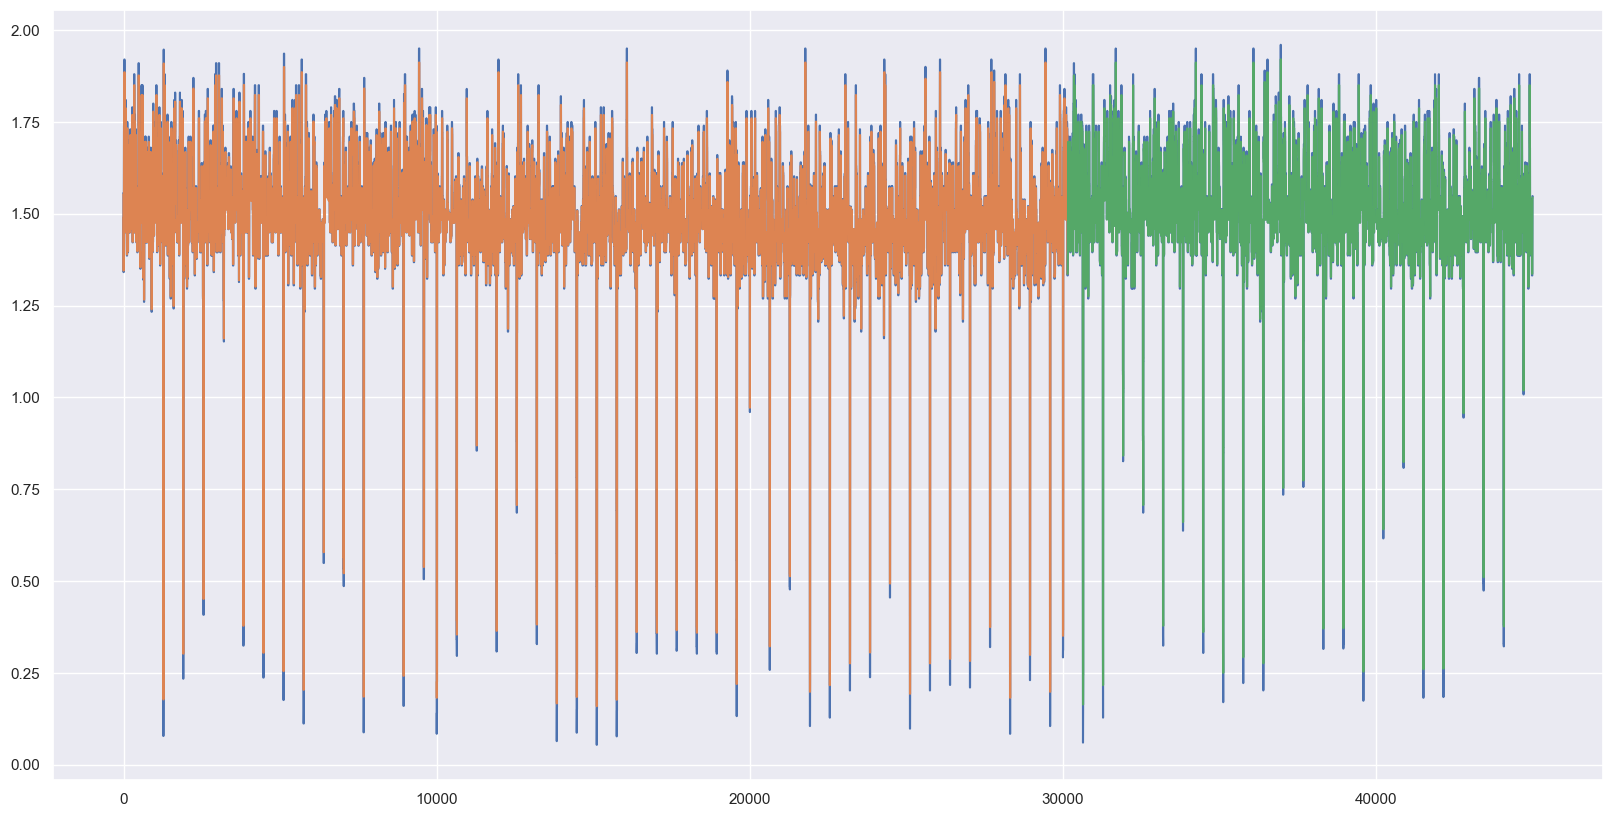

In [12]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_hor_cont_200)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_hor_cont_200)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_hor_cont_200)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_hor_cont_200))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [13]:
# Output of the splitting function
x_train, y_train, x_valid, y_valid, x_test, y_test = train_val_test_norm(data_hor_cont, 0.6, 0.3, "Pow_200")
print(x_train.shape, y_train.shape,
x_valid.shape, y_valid.shape,
x_test.shape, y_test.shape)
print(y_train)

(27000,) (27000,) (13499,) (13499,) (4501,) (4501,)
[1.55700004 1.55700004 1.34100008 ... 1.58400011 1.58400011 1.58400011]


In [14]:
### Vector Output CNN-LSTM Model
# Fitting the model
def model_fit(x_train, y_train, config):
  # Unpacking config
  n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
  n_input = n_seq * n_steps
  # Defining the model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
  model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(n_nodes, activation='relu'))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # Fitting the model
  model.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

# Forecasting with a pre-fit model
def model_predict(model, history, config):
  # Unpacking config
  n_seq, n_steps, _, _, _, _, _ = config
  n_input = n_seq * n_steps
  # Preparing data
  x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
  # Forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

# Walk-forward validation
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = sqrt(mean_squared_error(test, predictions))
  print(' > %.3f' % error)
  return error

In [15]:
### Multi-Head CNN-LSTM Model
# Defining the paramteres
#look_back = len(x_train)
#forecast_range = len(x_valid) + len(x_test)
#n_features = 1

# Defining the model
#input_layer = Input(shape=(look_back, n_features)) 
#head_list = []
#for i in range(0, n_features):
 #conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
 #conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='relu')(conv_layer_head)
 #conv_layer_flatten = Flatten()(conv_layer_head_2)
 #head_list.append(conv_layer_flatten)
 
#concat_cnn = Concatenate(axis=1)(head_list)
#reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
#lstm = LSTM(100, activation='relu')(reshape)
#repeat = RepeatVector(forecast_range)(lstm)
#lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
#dropout = Dropout(0.2)(lstm_2)
#dense = Dense(n_features, activation='linear')(dropout)
#multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

In [16]:
# run repeated experiment for parameters tuning
# need of refinement based on input
"""
def experiment(repeats, series, batch_size):
 # transform data to be stationary
 raw_values = series.values
 diff_values = difference(raw_values, 1)
 # transform data to be supervised learning
 supervised = timeseries_to_supervised(diff_values, 1)
 supervised_values = supervised.values
 # split data into train and test-sets
 train, test = supervised_values[0:-12], supervised_values[-12:]
 # transform the scale of the data
 scaler, train_scaled, test_scaled = scale(train, test)
 # run experiment
 error_scores = list()
 for r in range(repeats):
 # fit the model
 train_trimmed = train_scaled[2:, :]
 lstm_model = fit_lstm(train_trimmed, batch_size, 1000, 1)
 # forecast the entire training dataset to build up state for forecasting
 train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
 lstm_model.predict(train_reshaped, batch_size=batch_size)
 # forecast test dataset
 test_reshaped = test_scaled[:,0:-1]
 test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
 output = lstm_model.predict(test_reshaped, batch_size=batch_size)
 predictions = list()
 for i in range(len(output)):
 yhat = output[i,0]
 X = test_scaled[i, 0:-1]
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 # invert differencing
 yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
 # store forecast
 predictions.append(yhat)
 # report performance
 rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
 print('%d) Test RMSE: %.3f' % (r+1, rmse))
 error_scores.append(rmse)
 return error_scores

 # experiment
repeats = 30
results = DataFrame()
# vary training batches
batches = [1, 2, 4]
for b in batches:
 results[str(b)] = experiment(repeats, series, b)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_batches.png')
 """

"\ndef experiment(repeats, series, batch_size):\n # transform data to be stationary\n raw_values = series.values\n diff_values = difference(raw_values, 1)\n # transform data to be supervised learning\n supervised = timeseries_to_supervised(diff_values, 1)\n supervised_values = supervised.values\n # split data into train and test-sets\n train, test = supervised_values[0:-12], supervised_values[-12:]\n # transform the scale of the data\n scaler, train_scaled, test_scaled = scale(train, test)\n # run experiment\n error_scores = list()\n for r in range(repeats):\n # fit the model\n train_trimmed = train_scaled[2:, :]\n lstm_model = fit_lstm(train_trimmed, batch_size, 1000, 1)\n # forecast the entire training dataset to build up state for forecasting\n train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)\n lstm_model.predict(train_reshaped, batch_size=batch_size)\n # forecast test dataset\n test_reshaped = test_scaled[:,0:-1]\n test_reshaped = test_reshaped.reshape(len(tes